In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one, derivative_1d, solve_ode_neumann
from solver_jump import approach_one_100, solve_smooth_100, solve_jump_100
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import matplotlib.transforms as transforms
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['figure.edgecolor'] = 'w'

In [2]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*np.mean(θ_list)
ς = 0.1
# damage function
# ȳ = 1.9
γ1 = 0.00017675
γ2 = 2*0.0022
# γ3_list = np.linspace(0, 1/3, 40)
# γ3_list = np.array([0, 0.0197*2, 0.3853*2])
y_jump=2
y = 2.5
damage_min =  γ1*(y- y_jump+2) + γ2/2*(y - y_jump+2)**2
damage_max =  γ1*(y- y_jump+2) + γ2/2*(y - y_jump+2)**2 + 1/3/2*(y - y_jump)**2
damages = np.linspace(np.exp(-damage_max), np.exp(-damage_min), 40)
γ3_list = 2*( - np.log(damages) - γ1*(y- y_jump+2) - γ2/2*(y - y_jump+2)**2)/(y - y_jump)**2
γ3_list = np.flip(γ3_list)
γ3_list[0] = 0

dmg_weight = np.ones(len(γ3_list))/len(γ3_list)
# capital parameters
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0085
κ = 6.667
k0 = 80/α

In [3]:
γ3_list

array([0.        , 0.00837578, 0.01676033, 0.02515368, 0.03355585,
       0.04196685, 0.0503867 , 0.05881543, 0.06725304, 0.07569957,
       0.08415502, 0.09261941, 0.10109277, 0.10957512, 0.11806647,
       0.12656684, 0.13507625, 0.14359473, 0.15212228, 0.16065894,
       0.16920471, 0.17775962, 0.18632369, 0.19489694, 0.20347938,
       0.21207104, 0.22067194, 0.2292821 , 0.23790153, 0.24653026,
       0.25516831, 0.26381569, 0.27247243, 0.28113855, 0.28981407,
       0.298499  , 0.30719338, 0.31589721, 0.32461052, 0.33333333])

Text(0.5, 0, '$\\gamma_3$')

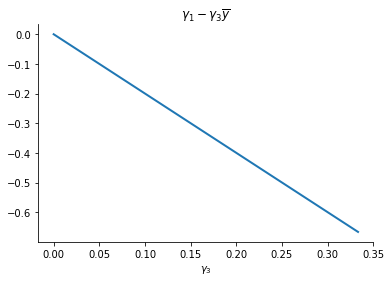

In [4]:
plt.plot(γ3_list, γ1 - γ3_list*2)
plt.title(r'$\gamma_1 - \gamma_3 \overline{y}$')
plt.xlabel(r'$\gamma_3$')
# plt.savefig('deri.png')

In [81]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [4]:
def solve_baseline(y_grid, numy_bar, ems_star, ϕ_list, args, ϵ=2, tol=1e-8, max_iter=3_000):
    """
    compute jump model with ambiguity over climate models
    """
    δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy = args
#     args_list = []
#     for γ3_i in γ3_list:
#         args_func = (δ, η, θ_list, σy, γ1, γ2, γ3_i, 2, ξa, ξw)
#         args_iter = (y_grid, args_func, 2000, 1e-7, 3)
#         args_list.append(args_iter)
  
#   res_list = ode_y_parallel(args_list)
    
#     ϕ_list = np.zeros((len(γ3_list), len(y_grid)))
#     for j in range(len(γ3_list)):
#         ϕ_list[j] = res_list[j]['φ']

#     ems_star = solu['ems']
    # solve for HJB with jump function
    y_grid_cap = y_grid[:numy_bar+1]
    dy = y_grid_cap[1] - y_grid_cap[0]
    dΛ = γ1 + γ2*y_grid_cap
    ddΛ = γ2
    πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)
    θ = θ_list@πᶜo 
    g_list = np.ones((len(γ3_list), len(y_grid_cap)))
    # coefficients
    A = -δ*np.ones(y_grid_cap.shape) - intensity*(dmg_weight@g_list)
    B = θ*ems_star
    C = σy**2*ems_star**2/2
    D = η*np.log(ems_star) + (η-1)/δ*dΛ*ems_star*θ + (η-1)/δ*ddΛ*ems_star**2*σy**2/2\
    + ξp*intensity * (dmg_weight@(1 - g_list + g_list * np.log(g_list)))\
    + intensity*((dmg_weight*ϕ_list[:, numy_bar])@g_list)
    
    ϕ_bound = np.average(ϕ_list, axis=0, weights=dmg_weight)[:numy_bar+1]
    ϕ = ϕ_bound
    episode = 0
    lhs_error = 1
    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, (0,0), False, "up")
        dϕdyy = derivative_1d(ϕ, 2, dy, (0,0), False, "up")
        # solver
        ϕ_new = solve_ode(A, B, C, D, y_grid_cap, ϕ, ϵ, (False, ϕ_bound[numy_bar]))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

#     dϕdy = derivative_1d(ϕ, 1, dy, "center")
#     dϕdyy = derivative_1d(ϕ, 2, dy, "center")
    
    ME = -(dϕdy+(η-1)/δ*dΛ)*θ - (dϕdyy+(η-1)/δ*ddΛ)*σy**2*ems_star
    ratio = ME/(η/ems_star)

    return ME, ratio

In [5]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θ_mat = θ_list.reshape(n_temp, n_carb)
θtemp_list = np.average(θ_mat, axis=1)
θcarb_list = np.average(θ_mat, axis=0)

In [17]:
from multiprocessing import Pool

# test for ξ_p = 2
# baseline
ξa = 0.01
ξw = 100_000
# ξp = 5
hy = 0.02
y_bar = 2
y_min = 0
y_max = 4
y_lower = 1.5

jump_interval = np.arange(y_lower,y_bar+hy, hy)
y_grid = np.arange(y_min, y_max+hy, hy)

In [25]:
def ode_y_parallel(args_list):
    with Pool(8) as p:
        res_list = p.starmap(solve_notrun, args_list)
    return res_list        

def ode_y_parallel_def(args_list):
    with Pool(8) as p:
        res_list = p.starmap(solve_smooth_100, args_list)
    return res_list        

In [23]:
def postjump_list(args_list):
    res_list = ode_y_parallel(args_list)
    ϕ_list = np.zeros((len(γ3_list), len(y_grid)))
    ems_list = np.zeros((len(γ3_list), len(y_grid)))
    for j in range(len(γ3_list)):
        ϕ_list[j ] = res_list[ j]['φ']
        ems_list[ j ] = res_list[ j]['ems']
        
    return ϕ_list, ems_list

def postjump_list_def(args_list):
    res_list = ode_y_parallel_def(args_list)
    ϕ_list = np.zeros((len(γ3_list), len(y_grid)))
    ems_list = np.zeros((len(γ3_list), len(y_grid)))
    for j in range(len(γ3_list)):
        ϕ_list[j ] = res_list[ j]['φ']
        ems_list[ j ] = res_list[ j]['ems']
        
    return ϕ_list, ems_list

In [26]:
args_list_1 = []

for γ3_i in γ3_list:
    args_func = (δ, η, θ_list, σy, γ1, γ2, γ3_i, 2, 0.01, 100_000)
    args_iter = (y_grid, args_func, 4000, 1e-7, 2)
    args_list_1.append(args_iter)

args_list_base  = []
for γ3_i in γ3_list:
    args_func = (δ, η, θ_list, σy, γ1, γ2, γ3_i, 2, 100_000, 100_000)
    args_iter = (y_grid, args_func, 4000, 1e-7, 2)
    args_list_base.append(args_iter)

In [27]:
# solve for approach two, step one, for individual ϕⱼ
def solve_notrun(y_grid, args, max_iter, tol, ϵ,):
    """
    solve for step one, ϕⱼ for individual damage function
    
    Parameter
    ---
    args: δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξa, ξw
    """
    δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξa, ξw = args
    dy = y_grid[1] - y_grid[0]
    n_y = len(y_grid)
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid-ȳ)
    ddΛ = γ2 + γ3
    ϕ = - η*y_grid**2
    ems = η
    ems_old = ems
    πo = np.ones((len(θ_list), n_y))/len(θ_list)
    lhs_error = 1
    episode = 0
    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, "up")
        dϕdyy = derivative_1d(ϕ, 2, dy, "up")
        temp = dϕdy + (η-1)/δ*dΛ
        # update belief
        weight = np.array([ - 1/ξa*temp*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        π = πo*np.exp(weight)
        π[π <= 1e-15] = 1e-15
        π = π/np.sum(π, axis=0)
        # update control
        a = (dϕdyy - 1/ξw*temp**2 + (η-1)/δ*ddΛ)*σy**2
        b = (θ_list@π)*temp
        c = η
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
        ems_new[ems_new < 1e-15] = 1e-15
        ems = ems_new*0.5 + ems_old*0.5
        # solve for ode
        A = - δ*np.ones(y_grid.shape)
        B = (θ_list@π)*ems
#         C = np.zeros(y_grid.shape)
        C = ems**2*σy**2/2
        D = η*np.log(ems) + (θ_list@π)*(η-1)/δ*dΛ*ems + ξa*np.sum(π*(np.log(π) - np.log(πo)), axis=0)\
        - 1/(2*ξw)*temp**2*ems**2*σy**2\
        + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2
        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        ems_old = ems
        episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    h = - temp*ems*σy/ξw
    solution = dict(ϕ=ϕ, ems=ems, πc=π)
    return solution

In [28]:
ϕ_list1, ems_list1 = postjump_list(args_list_1)
ϕ_list2, ems_list2 = postjump_list_def(args_list_1)
# ϕ_list_base, ems_list_base = postjump_list(args_list_base)

episode: 613,	 ode error: 0.0001104623867287935,	 ft error: 9.931367550564119e-08
episode: 605,	 ode error: 0.0014831350672399601,	 ft error: 9.922756342983785e-08
episode: 525,	 ode error: 0.0007102770160836436,	 ft error: 9.924464361432683e-08
episode: 1734,	 ode error: 0.003644597052895049,	 ft error: 9.251403021437454e-08
episode: 4000,	 ode error: 8.228173616529045,	 ft error: 0.27920762780017583
episode: 4000,	 ode error: 13.23641016901187,	 ft error: 2.820597848973705e-05
episode: 4000,	 ode error: 1.3905835939894817,	 ft error: 1.3818201956006249e-06
episode: 4000,	 ode error: 0.0067592538422868165,	 ft error: 8.808267060178565e-07
episode: 4000,	 ode error: 11.760872471066216,	 ft error: 0.648726356797475
episode: 784,	 ode error: 1.4764020291921958,	 ft error: 8.296387843387265e-08
episode: 4000,	 ode error: 1.5150922486370788,	 ft error: 1.201317177645933e-05
episode: 4000,	 ode error: 14.314758756475495,	 ft error: 1.9608104278034943e-06
episode: 4000,	 ode error: 0.0486509

In [42]:
ϕ_list1[:, 50]- ϕ_list2[:,50]

array([-1.32627027e-04,  3.48090339e-01,  6.88707625e-01,  1.02502509e+00,
        1.36156633e+00,  1.69863115e+00,  2.03490352e+00,  2.37425297e+00,
        2.71534565e+00, -4.00618314e+00,  3.40259192e+00,  3.75039936e+00,
        4.09915096e+00,  4.44948606e+00,  4.79221882e+00,  5.15798911e+00,
        5.51452050e+00,  5.87347306e+00,  6.14555143e+00,  6.59733914e+00,
        6.96096500e+00,  7.32461878e+00,  7.69425351e+00,  8.06204433e+00,
        8.29127308e+00,  8.79795219e+00,  9.17755969e+00,  9.39876329e+00,
        9.88001392e+00,  1.03008055e+01,  1.06805216e+01,  1.10519378e+01,
        1.12701107e+01,  1.17900966e+01,  1.21837410e+01, -1.69707532e+00,
        1.29571452e+01,  1.33276862e+01, -3.18396775e-01,  1.40861244e+01])

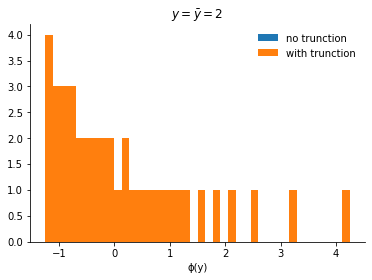

In [63]:
plt.hist(ϕ_list1[:,100], bins=40, label="no trunction")
plt.hist(ϕ_list2[:,100], bins=40, label="with trunction")
plt.legend()
plt.title(r'$y = \bar{y} = 2$')
plt.xlabel('ϕ(y)')
plt.savefig('trunc.png', dpi=400)

In [55]:
y_grid[50]

1.0

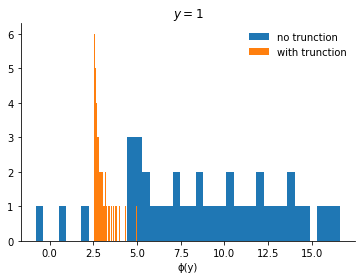

In [64]:
plt.hist(ϕ_list1[:,50], bins=40, label="no trunction")
plt.hist(ϕ_list2[:,50], bins=40, label="with trunction")
plt.legend()
plt.title(r'$y = 1$')
plt.xlabel('ϕ(y)')
plt.savefig('trunc1.png', dpi=400)

In [61]:
y_grid[150]

3.0

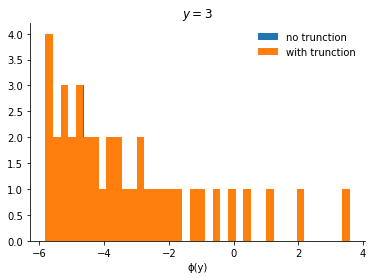

In [65]:
plt.hist(ϕ_list1[:,150], bins=40, label="no trunction")
plt.hist(ϕ_list2[:,150], bins=40, label="with trunction")
plt.legend()
plt.title(r'$y = 3$')
plt.xlabel('ϕ(y)')
plt.savefig('trunc2.png', dpi=400)

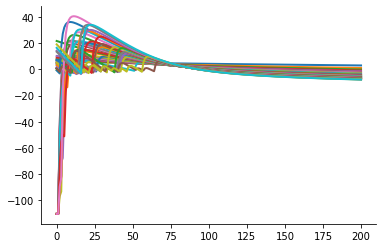

In [67]:
plt.plot(ϕ_list1.T)

In [ ]:
# prep_dict = dict(
#     ϕ_list=ϕ_list, ems_list=ems_list, 
#     ϕ_list_base=ϕ_list_base, ems_list_base=ems_list_base,
#     me_list=me_list, ratio_list=ratio_list
# )

# pickle.dump(prep_dict, open("../data/prep_dict_40.p", "wb"))

In [ ]:
res_dict = pickle.load(open('../data/prep_dict_40.p', 'rb'))

ϕ_list = res_dict['φ_list']
ems_list = res_dict['ems_list']
ϕ_list_base = res_dict['φ_list_base']
ems_list_base = res_dict['ems_list_base']
me_list = res_dict['me_list']
ratio_list = res_dict['ratio_list']

In [ ]:
# construct ϕ_m
pre_jump = np.arange(y_min, 2 + hy, hy)
prepre_jump = np.arange(y_min, y_lower, hy)

In [ ]:
plt.plot(ϕ_list[1])
plt.plot(ϕ_list_base[1])
plt.show()

In [ ]:
def solve_baseline_prep(y_grid, ems_star, args, ϵ=2, tol=1e-8, max_iter=3_000):
    """
    compute jump model with ambiguity over climate models
    """
    δ, η, θ_list, γ1, γ2, γ3, ȳ, dmg_weight, ξp, ξa, ξw, σy = args
#     ems_star = solu['ems']
    # solve for HJB with jump function
#     y_grid_cap = y_grid[:numy_bar+1]
    numy_bar = len(pre_jump)
    dy = y_grid[1] - y_grid[0]
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid - ȳ)*(y_grid>ȳ)
    ddΛ = γ2 + γ3*(y_grid>ȳ)
    πᶜo = np.ones((len(θ_list), len(y_grid)))/len(θ_list)
    θ = θ_list@πᶜo 
    A = -δ*np.ones(y_grid.shape)
    B = θ*ems_star
    C = σy**2*ems_star**2/2
    D = η*np.log(ems_star) + (η-1)/δ*dΛ*ems_star*θ + (η-1)/δ*ddΛ*ems_star**2*σy**2/2
    
    ϕ_bound = np.average(ϕ_list, axis=0, weights=dmg_weight)
    ϕ = ϕ_bound
    episode = 0
    lhs_error = 1
    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, (0,0), False, "up")
        dϕdyy = derivative_1d(ϕ, 2, dy, (0,0), False, "up")
        # solver
        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, ϕ_bound[numy_bar]))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

#     dϕdy = derivative_1d(ϕ, 1, dy, "center")
#     dϕdyy = derivative_1d(ϕ, 2, dy, "center")
    
    ME = -(dϕdy+(η-1)/δ*dΛ)*θ - (dϕdyy+(η-1)/δ*ddΛ)*σy**2*ems_star
    ratio = ME/(η/ems_star)

    return ME, ratio

In [ ]:
# me_list = np.zeros((len(γ3_list), len(y_grid)))
# ratio_list = np.zeros((len(γ3_list), len(y_grid)))

# for i in range(len(γ3_list)):
#     args_baseline = (δ, η, θ_list, γ1, γ2, γ3_list[i], 2, dmg_weight, 100_000, 100_000, 100_000, σy )
#     ems_star = ems_list[i]
#     me_baseline = solve_baseline_prep(y_grid, ems_star, args_baseline, ϵ=1)
#     me_list[i] = me_baseline[0]
#     ratio_list[i] = me_baseline[1]

# Step 2: HJB

In [ ]:
ξa = 0.01
ξw = 100_000
σy=1.2*np.mean(θ_list)

loc_21 = np.abs(y_grid - 2.1).argmin()
# num_21 = loc
# numy_bar = len(pre_jump) -1
# y_grid_cap = y_grid[:numy_bar+1]
loc_2 =  np.abs(y_grid - 2).argmin()

ϕ_ref = np.zeros((len(γ3_list), loc_21+1 ))
for i in range(len(γ3_list)):
    ϕ_ref[i] = ϕ_list[i, loc_2]



def solve_interval(y_grid, num_stop, num_bound, ϕ_ref, ϕ_list,
                   args,
                   with_bound=False,
                   ϵ=0.3, tol=1e-8, max_iter=4000): 
    
    ξa, ξw, ξp = args
    r1=1.5
    r2=2.5
    y_grid_cap = y_grid[:num_stop+1]
    y_lower = 1.5
    intensity = r1*(np.exp(r2/2*(y_grid_cap- y_lower)**2)-1) *(y_grid_cap >= y_lower)
    # intensity[96:101] = [1.33, 2.33, 3.33, 4.33, 5.33]
    # ς = 0.25
    # intensity = 1/(np.sqrt(2)*ς)*np.exp(-(y_grid_cap - 2)**2/(2*ς**2))
    # intensity = 0.3/(1.9-1.5)*(y_grid_cap - 1.5)*(y_grid_cap>1.5) + 300*(y_grid_cap - 1.9)**2*(y_grid_cap>1.9)

    
    dΛ = γ1 + γ2*y_grid_cap
    ddΛ = γ2

    ϕ = np.average(ϕ_list, axis=0, weights=dmg_weight)[:num_stop+1]

    
    dy = hy
    ems = η
    ems_old = ems
    episode = 0
    lhs_error = 1
    πᵈo = dmg_weight
    πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)

    ϕ_average2 = np.average( np.exp(-1/ξp*ϕ_list), weights=dmg_weight, axis=0)
    ϕ_bound = -ξp*np.log(ϕ_average2)


    tol= 1e-8
    ϵ = 0.3
    max_iter = 4000
    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, (0,0),  False, "up")
        dϕdyy = derivative_1d(ϕ, 2, dy, (0,0), False, "up")
        # update control
        temp = dϕdy + (η-1)/δ*dΛ 
        weight = np.array([ - 1/ξa*temp*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πᶜ = πᶜo*np.exp(weight)
        πᶜ[πᶜ <= 1e-15] = 1e-15
        πᶜ = πᶜ/np.sum(πᶜ, axis=0)
        # update control

        if σy == 0:
            ems_new = - η/(temp*(θ_list@πᶜ))
        else:
            a = (dϕdyy  - 1/ξw*temp**2 + (η-1)/δ*ddΛ)*σy**2
            b = (θ_list@πᶜ)*temp
            c = η
            Δ = b**2 - 4*a*c
            Δ[Δ < 0] = 0
            root1 = (-b - np.sqrt(Δ))/(2*a)
            root2 = (-b + np.sqrt(Δ))/(2*a)
            if root1.all() > 0:
                ems_new = root1
            else:
                ems_new = root2

        ems_new[ems_new < 1e-15] = 1e-15
        ems = ems_new*0.5 + ems_old*0.5



        g_list = np.exp(1/ξp*(ϕ - ϕ_ref))
        # coefficients
        A = -δ*np.ones(y_grid_cap.shape)  - intensity*(dmg_weight@g_list)
        By = (θ_list@πᶜ)*ems
        Cyy = ems**2*σy**2/2
        D = η*np.log(ems) + θ_list@πᶜ*(η-1)/δ*dΛ*ems\
        + ξa*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0) \
        + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2\
        - 1/(2*ξw)*temp**2*ems**2*σy**2\
        + ξp*intensity * (dmg_weight@(1 - g_list + g_list * np.log(g_list)))\
        + intensity*(dmg_weight@(g_list*ϕ_ref))
        # solver

        ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ,(with_bound, ϕ_bound[num_bound]))
        rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        episode += 1
        ems_old = ems

    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    ent = ξa*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0)

    solution = dict(ϕ=ϕ, ems=ems, g_list=g_list, ϕ_bound=ϕ_bound, dϕ=dϕdy, ddϕ=dϕdyy, πc = πᶜ, en=ent)
    return solution

In [ ]:
ϕ_ref = np.zeros((len(γ3_list), loc_2+1 ))
for i in range(len(γ3_list)):
    ϕ_ref[i] = ϕ_list[i, loc_2]

soluDict = dict()
for ξp in [5,1, 0.3]:
    soluDict[ξp] = solve_interval(
        y_grid, loc_2, loc_2, ϕ_ref, ϕ_list, (0.01, 100_000, ξp), False
    )
    
soluDict[100_000] = solve_interval(
        y_grid, loc_2, loc_2, ϕ_ref, ϕ_list_base, (100_000, 100_000, 100_000), False
    )

In [ ]:
y_grid_cap = y_grid[:loc_2+1]
plt.figure(figsize=(10,5))
plt.plot(y_grid_cap,soluDict[1]['en']/0.01)
plt.ylim(0,0.4)
plt.ylabel('Relative entropy')
plt.xlabel('y')
# plt.savefig('entropy.pdf', bbox_inches='tight')

In [ ]:
plt.figure(figsize=(10,5))
numy_bar = loc_2
plt.plot(y_grid_cap,soluDict[1]['φ'], label="prior to jump")
# plt.plot(y_grid[numy_bar: len(pre_jump)], cert_equiv[numy_bar:])
plt.plot(y_grid[numy_bar:], soluDict[1]['φ_bound'][numy_bar:], label="certainty equivalent", color="black")
plt.plot(y_grid[numy_bar:], np.quantile(ϕ_list[ :, numy_bar:], 0.1, axis=0), label=".10 quantile")
plt.plot(y_grid[numy_bar:], np.quantile(ϕ_list[ :, numy_bar:], 0.33, axis=0), label=".33 quantile")
plt.plot(y_grid[numy_bar:], np.quantile(ϕ_list[ :, numy_bar:], 0.5, axis=0), label=".50 quantile")
plt.plot(y_grid[numy_bar:], np.quantile(ϕ_list[ :, numy_bar:], 0.67, axis=0), label=".67 quantile")
plt.plot(y_grid[numy_bar:], np.quantile(ϕ_list[ :, numy_bar:], 0.9, axis=0), label=".90 quantile")
# plt.plot(y_grid, solution_low["ems"])
# plt.plot(y_grid_cap, ems_ref.T)
# plt.title("Value function", fontsize=12)
plt.xlabel('y')
plt.vlines(2, -8, 4, color="black", linestyle="dashed")
plt.legend()

plt.ylabel('ϕ(y)')
plt.xlim(0,3)
# plt.savefig('value_match.pdf')
plt.show()

In [ ]:
plt.hist(ϕ_list[  :, numy_bar], weights=np.ones_like(ϕ_list[ :, numy_bar])/len(ϕ_list), bins=20, alpha=0.5, ec="gray")
plt.xlabel("$\phi_m(2)$")
# plt.savefig('../figures/histogram_valuefunc.pdf')

In [ ]:
# intensity
r1 = 1.5
r2 = 5
intensity1 = r1*(np.exp(r2/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)
intensity = r1*(np.exp(2.5/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)
# worst_case_intensity = dmg_weight@g_list*intensity1
# plt.plot(y_grid_cap, worst_case_intensity, label="implied worst case intensity")
plt.plot(y_grid_cap, intensity1, label="r2 =5")
plt.plot(y_grid_cap, intensity, label="r2 = 2.5")
plt.xlabel('y')
plt.ylabel('$\mathcal{I}(y)$')
plt.legend()
# plt.savefig('../figures/20_damages_large/intensity_{}.pdf'.format( ξp))

In [ ]:
meDict = {}
ratioDict = {}
for i, ξp in enumerate([100_000, 5, 1, 0.3]):
    args_base = (δ, η, θ_list, γ1, γ2, γ3_list, 2, dmg_weight, ς, 100_000, 100_000, 100_000, σy)
    me, ratio = solve_baseline(y_grid, numy_bar, soluDict[ξp]['ems'], ϕ_list, args_base, ϵ=0.2)
    meDict[ξp] = me
    ratioDict[ξp] = ratio

In [ ]:
for i in [1.6, 1.7, 1.8, 1.9, 2]:
    loc_1 = np.abs(y_grid_cap - i).argmin()
    print(i, intensity1[loc_1])

In [ ]:
dt = 1/4

In [ ]:
for ξp in [100_000, 5, 1, 0.3]:
    plt.plot(y_grid_cap, soluDict[ξp]['ems'], label="{}".format(ξp))
plt.legend()

In [ ]:
def no_jump_simulation(ems, g_list, πc, me, dt, r1, r2):
    y = 1.1
    T = 130
    T = int(T/dt)
    et = np.zeros(T)
    yt = np.zeros(T)
    met = np.zeros(T)
    probt = np.zeros(T)
    gt = np.zeros((T, len(g_list)))
    get_g = interpolate.interp1d(y_grid_cap, g_list)
    πct = np.zeros((T, len(πc)))
    get_π = interpolate.interp1d(y_grid_cap, πc)
    for t in range(T):
#         if y < 1.5:
#             print(t)
        if y <= 2:
            e_i = np.interp(y, y_grid_cap, ems)
            me_i = np.interp(y, y_grid_cap, me)
            intensity = r1*(np.exp(r2/2*(y - y_lower)**2) - 1)*(y > y_lower)
    #             intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            et[t] = e_i
            met[t] = me_i
    #             met[t] = me_i
            probt[t] = 1-intensity*dt
            yt[t] = y
            g_list = get_g(y)
            gt[t] = g_list
            πc_i  = get_π(y)
            πct[t] = πc_i
            y = y + e_i*np.mean(θ_list)*dt
#         else:
#             break
    yt = yt[np.nonzero(yt)]
    et = et[np.nonzero(et)]
    met = met[np.nonzero(met)]
    probt = probt[np.nonzero(probt)]
    gt = gt[:len(yt)]
    πct = πct[:len(yt)]

    return et, yt, probt, πct, gt, met

In [ ]:
simulDict = dict()
for ξp in [ 100_000, 5, 1, 0.3]:
    solution = soluDict[ξp]
    simulDict[ξp] = no_jump_simulation(ems=solution['ems'],g_list=solution['g_list'],
                                       πc = solution['πc'],
                                   me=meDict[ξp], dt=dt, r1=1.5, r2=2.5)

In [ ]:
# emission
colors = ["tab:red", "darkorange", "darkgreen", "navy"]
names = ['baseline', r"$\xi_p = 5$",r"$ \xi_p = 1$", r"$\xi_p = 0.3$"]
fig, (ax1) = plt.subplots(1, 1, figsize=(8,5))
for i, ξp in enumerate([100_000,  5, 1, 0.3]):
    Yt = simulDict[ξp][1]
    loc = np.abs(Yt - 1.5).argmin()
    ax1.plot(np.arange(0, loc*dt, dt), simulDict[ξp][0][:loc], 
             color=colors[i], linewidth=2.5,
            label=names[i])
    ax1.set_ylabel('Emissions', size=13)
    ax1.set_xlabel('Years', size=13)
    ax1.legend(loc=3)
    ax1.set_ylim(0,6)
#     ax2.plot(np.arange(0, loc*dt, dt), simulDict[ξp][1][:loc])
#     ax2.set_title('Temperature ani')
#     ax2.set_xlabel('Years')

# plt.savefig('../figures/emission_pre_jump.pdf', bbox_inches='tight')

In [ ]:
# log
colors = ["tab:red", "darkorange", "darkgreen", "navy"]
names = ['baseline', r"$\xi_p = 5$",r"$ \xi_p = 1$", r"$\xi_p = 0.3$"]

C0 = (α - invkap)/α*80
fig, ax = plt.subplots(1, 1, figsize=(8,5))
for i, ξp in enumerate([100_000,  5, 1, 0.3]):
    Et = simulDict[ξp][0]
    Yt = simulDict[ξp][1]
    loc = np.abs(Yt - 1.5).argmin()
    logNt = γ1*Yt + γ2/2*Yt**2
    logscc = np.log(1000) + np.log(C0) - logNt - np.log(Et) + np.log(η) - np.log(1-η)
    ax.plot(np.arange(0, loc*dt, dt), logscc[:loc], 
             color=colors[i], linewidth=2.5,
            label=names[i])
    ax.set_ylabel('Emissions', size=13)
    ax.set_xlabel('Years', size=13)
    ax.legend(loc=2)
# plt.savefig('../figures/logscc_pre_jump.pdf', bbox_inches='tight')

In [ ]:
# scc as function of y
colors = [ "navy", "darkorange", "darkgreen", "tab:red",]
names = [ r"$ \xi_p = 0.3$",r"$ \xi_p = 1$", 
         r"$\xi_p = 5$", 'baseline']

C0 = (α - invkap)/α*80

fig, (ax1) = plt.subplots(1, 1, figsize=(8,5))
for i, ξp in enumerate([0.3, 1, 5, 100_000]):
    E = soluDict[ξp]['ems']
#     Et = soluDict[ξp][0]
    SCC = np.log(1000) + np.log(C0)  - (y_grid_cap*γ1 + γ2/2*y_grid_cap**2) \
        -np.log(E) + np.log(η) - np.log(1- η)
#     print(SCCt[0])
#     loc = np.abs(Yt - 1.5).argmin()
    ax1.plot(y_grid_cap[110:151], SCC[110:151], 
             color=colors[i], linewidth=2.5,
            label=names[i])
    ax1.set_ylabel(r'$\log SCC$', size=13)
    ax1.set_xlabel('Temperature anomaly', size=13)
    ax1.legend(loc=2)
    
# fig.savefig('../figures/logscc_pre_jump_y.pdf', bbox_inches="tight")

In [ ]:
colors = ["tab:red", "darkgreen", "navy"]
names = ['baseline', r"$\xi_a = 0.01, \xi_p = 5$", r"$\xi_b = \xi_p = 0.3$"]
fig, (ax1) = plt.subplots(1, 1, figsize=(8,5))
for i, ξp in enumerate([100_000,  5,  0.3]):
    Yt = simulDict[ξp][1]
#     loc = np.abs(Yt - 1.5).argmin()
    ax1.plot(np.arange(0, len(simulDict[ξp][0])*dt, dt), simulDict[ξp][0], 
             color=colors[i], linewidth=2.5,
            label=names[i])
    ax1.set_ylabel('Emissions')
    ax1.set_xlabel('Years')
    ax1.legend(loc=2, fontsize=12)
    ax1.set_ylim(0)
#     ax2.plot(np.arange(0, loc*dt, dt), simulDict[ξp][1][:loc])
#     ax2.set_title('Temperature ani')
#     ax2.set_xlabel('Years')

# fig.savefig('emission_full.png', dpi=500)

In [ ]:
# hist γ3
fig, axes = plt.subplots(1,3, figsize=(19,5))
colors = ["tab:blue", "tab:red", "tab:green"]
names = ['baseline', 
         r"$\xi_a = 0.01, \xi_p = 5$", 
         r"$\xi_a = 0.01, \xi_p = 1$",
         r"$\xi_a =0.01,  \xi_p = 0.3$"]

for i, ξp in enumerate([ 5, 1 ,0.3]):
    axes[i].hist(
        γ3_list, 
        weights=simulDict[100_000][-2][-1]*dmg_weight/np.sum(simulDict[100_000][-2][-1]*dmg_weight), 
        color=colors[1],
        label = names[0],
         bins=20, ec="gray", alpha=0.5)
    axes[i].hist(γ3_list, weights=simulDict[ξp][-2][-1]*dmg_weight/np.sum(simulDict[ξp][-2][-1]*dmg_weight), 
        color=colors[0],
             label = names[i+1],
         bins=20, ec="gray", alpha=0.5)
#     axes[i].legend(loc=2)
    axes[i].set_ylim(0, 0.27)
    
    axes[i].set_xlabel('$γ_3$')
# plt.legend()
# plt.savefig("../figures/damage_hist_distort.pdf", bbox_inches='tight')

In [ ]:
# histograms of the climate models
plt.figure(figsize=(6, 5))
bins = np.linspace(0., 3., 21)
plt.hist(θ_list*1000, weights=np.ones_like(θ_list)/len(θ_list), 
         bins=bins, 
         density = True,
         alpha=0.5, 
         color="tab:red",
         ec = 'gray')
plt.hist(θ_list*1000, weights = simulDict[1][-3][-1], 
         alpha=0.5,
         density=True,
         color="tab:blue", 
         bins=bins,
        ec="gray")

plt.ylim(0,1.5)
plt.xticks(np.arange(0,3+0.5, 0.5))
plt.xlim(.8, 3)
plt.xlabel('Climate sensitivity', size=13)
plt.ylabel('Density', size=13)

# plt.savefig('../figures/climate_worstcase.pdf', bbox_inches='tight')

In [ ]:
T_jump = np.abs(simul_no1[1]-1.5).argmin()
T_stop = (len(simul_no1[0])-1)*dt
T_jump/4, T_stop, simul_no1[1][T_jump]

In [ ]:
# no jump & temperature anomaly
simul_no1 = simulDict[1]
yt = simul_no1[1]
T_jump = (np.abs(simul_no1[1]-1.5).argmin())*dt
T_stop = (len(simul_no1[0])-1)*dt


Years = np.arange(0, T_stop + dt, dt)
prob_no_jump = np.cumprod(simul_no1[2])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
# fig.suptitle('{} damage specifications'.format(len(dmg_weight)), y=0.99)


ax1.plot(Years, 1 -np.cumprod(simul_no1[-4]))
# ax1.set_title("No jump probability")
ax1.set_xlabel('Years')
ax1.set_ylim(0)
ax1.set_xlim(0,100)
# ax1.hlines(np.min(prob_no_jump), 0, T_stop-1, color="red", linestyle="dashed")
trans = transforms.blended_transform_factory(
    ax1.get_yticklabels()[0].get_transform(), ax1.transData)

# ax1.text(-0.01,np.min(prob_no_jump)+0.05, "{:.05f}".format(np.min(prob_no_jump)), color="red", transform=trans, 
#         ha="right", va="center")

# ax1.text(0.98, -0.061, int(np.ceil(T_stop)), transform=trans, ha="right", va="center")
# ax1.text(1.0, -0.056, int(np.ceil(T_stop)), transform=trans, ha="right", va="center")
ax1.text(1.06, -0.056, 100, transform=trans, ha="right", va="center")
# ax2.text(0.567, 0.9455, int(np.ceil(T_jump)), transform=trans, ha="right", va="center")
ax1.set_xticks(np.arange(0,100, 20))
# ax1.set_xticks([99, 100], minor=True)

ax2.plot(Years, simul_no1[1])
ax2.hlines(1.5, 0, T_jump, color="black", linestyle="dashed")
ax2.vlines(T_jump, 1, 1.5, color="black", linestyle="dashed" )
ax2.hlines(2, 0, T_stop, color="black", linestyle="dashed")
ax2.vlines(T_stop, 1, 2, color="black", linestyle="dashed" )
ax2.set_xlim(0) 
# ax2.set_title('Temperature anomaly')
ax2.set_xlabel('Years')
ax2.set_ylim(1,2.03)
trans = transforms.blended_transform_factory(
    ax2.get_yticklabels()[0].get_transform(), ax2.transData)

ax2.text(0,1.5, 1.5, color="black", transform=trans, ha="right", va="center")

# ax2.text(0.97, 0.948, int(np.ceil(T_stop)), transform=trans, ha="right", va="center")
ax2.text(1.02, 0.948, 100, transform=trans, ha="right", va="center")
# ax2.text(0.567, 0.948, int(np.ceil(T_jump)), transform=trans, ha="right", va="center")
ax2.set_xticks(np.arange(0,100, 20))
ax2.set_xticks([56, 99], minor=True)
fig.tight_layout()

# fig.savefig("../figures/prob_anomaly.pdf")
fig.savefig('prob_anomaly.pdf',dpi=500, bbox_inches='tight')

In [ ]:
T_jump, (len(simul_no1[0])-1)/4

In [ ]:
# scc
logkt = simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, dt=dt, T=120)
MCt = (1 - η)/((α - invkap)*np.exp(logkt))

for i, ξp in enumerate([ 100_000, 5,  1, 0.3]):
    fig = plt.figure(figsize=(8,5))

    et_star = simulDict[ξp][0]
    scc = η/et_star/MCt[:len(et_star)]*1000
    scc0 = simulDict[ξp][-1]/MCt[:len(et_star)]*1000 
    plt.plot(np.arange(0, len(et_star)*dt, dt), scc, color="rebeccapurple", label="Total")

    plt.plot(np.arange(0, len(et_star)*dt, dt), scc -scc0, color="rebeccapurple", 
             linestyle="dashed", label="Uncertainty")
    plt.fill_between(np.arange(0, len(et_star)*dt, dt), np.zeros_like(scc), 
                     scc-scc0, color='rebeccapurple', alpha=.4)
    
    T_jump = (np.abs(simulDict[ξp][1]-1.5).argmin())*dt
#     T_jump = len(et_star)*dt
    
    uncertainty = (scc - scc0)/scc
    for y in [10*4, 30*4, 50*4]:
        print(ξp, y/4, uncertainty[y])
    
    plt.xlim(0, T_jump)
    plt.ylim(0,850)
    plt.xlabel("Years")
    plt.ylabel("SCC ($/tC)")
    plt.legend(loc=2)
    plt.title(r'SCC, pre jump, $\xi_p$ = {}'.format( ξp ))
    print(((scc -scc0)/scc)[int(T_jump/dt)], simulDict[ξp][1][int(T_jump/dt)])
    
#     plt.savefig("../figures/20_damages_large/scc_{}.png".format(ξp), dpi=500)

In [ ]:
###### scc
logkt = simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, dt=dt, T=120)
MCt = (1 - η)/((α - invkap)*np.exp(logkt))

for i, ξp in enumerate([ 100_000, 5,  1, 0.3]):

    et_star = soluDict[ξp]['ems']
    ratio = ratioDict[ξp]
    for y_star in np.arange(1.1, 1.6, 0.1):
        loc = np.abs(y_grid_cap - y_star).argmin()
        print(ξp, y_star, "{:.4f}".format(1-ratio[loc]))
    
#     plt.savefig("../figures/20_damages_large/scc_{}.png".format(ξp), dpi=500)

In [ ]:
def jump_simulation(ems, ems_list, me, ratio, dt, r1, r2):
    θ_mean = np.mean(θ_list)
#     ems = solution['ems']
#     ϕ=solution["φ"]
#     ems_list = res_dict['ems_list']
    y0 = 1.1
    y_lower = 1.5
    T_year = 120
    T = int(T_year/dt)
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    
    y = y0
    for t in range(T):
        if y < y_lower:
            e_i = np.interp(y, y_grid_cap, ems)
            intensity = r1*(np.exp(r2/2*(y - y_lower)**2) - 1)*(y > y_lower)
#             intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            et[t] = e_i
            probt[t] = 1 - intensity*dt
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            yt[t] = y
            y = y + et[t]*θ_mean*dt
        else:
            T_jump = t
            print(T_jump)
            break
    
    # get time span before 
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    y = y0
    for t in range(T):
        print(t)
        if y <= y_bar:
            e_i = np.interp(y, y_grid_cap, ems)
            intensity = r1*(np.exp(r2/2*(y - y_lower)**2) - 1)*(y > y_lower)
#             intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            et[t] = e_i
            probt[t] = 1- intensity*dt
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            yt[t] = y
            y = y + et[t]*θ_mean*dt
    
    yt_nojump = yt[np.nonzero(yt)]
    et_nojump = et[np.nonzero(et)]
    
    T_final = len(yt_nojump)
    print(T_final)
    T_extra = T - T_final
    
    PROB = np.zeros((len(dmg_weight)*(T_final-T_jump)+1, T+1))
    EMS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    Temp_anol = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    YS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    GS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    ME = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    RATIO = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    y = y0        
    for t in range(T_jump):
        print(t)
        e_i = np.interp(y, y_grid_cap, ems)
        me_i = np.interp(y, y_grid_cap, me)
        ratio_i = np.interp(y, y_grid_cap, ratio)
        intensity = r1*(np.exp(r2/2*(y - y_lower)**2) - 1)*(y > y_lower)
#         intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
        et[t] = e_i
        probt[t] = 1 - intensity*dt
        prob_no[t] = np.cumprod(probt[:t+1])[-1]
        yt[t] = y
        YS[:,t] = y
        Temp_anol[:, t] = y
        PROB[0, t] = prob_no[t]
        EMS[:, t] = et[t]
        ME[:, t] = me_i
        RATIO[:, t] = ratio_i
        y = y + et[t]*θ_mean*dt
    
    
    
    
    for t in range(T_jump, T_final):
        print(t)
        if t == T_jump:
            intensity = r1*(np.exp(r2/2*(y-y_lower)**2) - 1)*(y > y_lower)
#             intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            e_stay = np.interp(y, y_grid_cap, ems)
            me_i = np.interp(y, y_grid_cap, me)
            ratio_i = np.interp(y, y_grid_cap, ratio)
            EMS[0, t] = e_stay
            probt[t] = 1-intensity*dt
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            PROB[0, t] = prob_no[t]
            YS[0, t] = y
            Temp_anol[0, t] = y
            ME[0, t] = me_i
            RATIO[0, t] = ratio_i
            et[t] = e_stay
            yt[t] = y
            y = y + et[t]*θ_mean*dt

            for dmg in range(len(dmg_weight)):
#                 loc = np.abs(yt[t]-y_grid).argmin()
                PROB[dmg+1, t] = intensity*dt*dmg_weight[dmg]
                YS[dmg+1, t] =  2
                EMS[dmg+1, t] = np.interp(2, y_grid, ems_list[dmg])
                ME[dmg+1, t] = np.interp(2, y_grid, me_list[dmg])
                RATIO[dmg+1, t] = np.interp(2, y_grid, ratio_list[dmg])
                Temp_anol[dmg + 1, t] = yt[t]
            
            for t_future in range(1, T_final-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + t_future*len(dmg_weight) +1
#                     PROB[id_dmg, t] = PROB[0, t]
                    EMS[id_dmg, t] = e_stay
                    YS[id_dmg, t] = yt[t]
                    ME[id_dmg, t] = me_i
                    RATIO[id_dmg, t] = ratio_i
                    Temp_anol[id_dmg, t] = yt[t]

#                 PROB[:, 0] = PROB[:,0]/np.sum(PROB[:,0])

            yt[t+1] = yt[t] + et[t]*θ_mean*dt   

        elif t > T_jump:
            intensity = r1*(np.exp(r2/2*(y-y_lower)**2) - 1)*(y > y_lower)
#             intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            e_stay = np.interp(y, y_grid_cap, ems)
            me_i = np.interp(y, y_grid_cap, me)
            ratio_i = np.interp(y, y_grid_cap, ratio)
            EMS[0, t] = e_stay
            probt[t] = 1-intensity*dt
            prob_no[: t+1] = np.cumprod(probt[:t+1])
            PROB[0, t] = prob_no[t]
            ME[0, t] = me_i
            RATIO[0, t] = ratio_i
            YS[0, t] = y
            Temp_anol[0, t] = y
            et[t] = e_stay
            yt[t] = y
            y = y + et[t]*θ_mean*dt

            for time in range(t-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + time*len(dmg_weight) +1
#                     loc = np.abs(yt[time+T_jump]-y_grid).argmin()
                    PROB[id_dmg, t] = PROB[id_dmg, t-1]*1
                    EMS[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ems_list[dmg])
                    ME[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, me_list[dmg])
                    RATIO[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ratio_list[dmg])
                    YS[id_dmg, t] = YS[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt
                    Temp_anol[id_dmg, t] = Temp_anol[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt

            for dmg in range(len(dmg_weight)):
#                 loc = np.abs(yt[t]-jump_interval).argmin()
                id_dmg = dmg + (t-T_jump)*len(dmg_weight) +1
                PROB[id_dmg, t] = PROB[0, t-1]*intensity*dt*dmg_weight[dmg]
                YS[id_dmg, t] = 2
                EMS[id_dmg, t] = np.interp(2, y_grid, ems_list[dmg])
                RATIO[id_dmg, t] = np.interp(2, y_grid, ratio_list[dmg])
                ME[id_dmg, t] = np.interp(2, y_grid, me_list[dmg])
                Temp_anol[id_dmg, t] = yt[t]
                
            
            for t_future in range(t-T_jump+1, T_final-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + t_future*len(dmg_weight) +1
#                     PROB[id_dmg, t] = PROB[0, t]
                    EMS[id_dmg, t] = e_stay
                    YS[id_dmg, t] = yt[t]
                    Temp_anol[id_dmg, t] = yt[t]
                    ME[id_dmg, t] = me_i
                    RATIO[id_dmg, t] = ratio_i
        
    for t in range(T_final, T+1):
        print(t)
        EMS[0, t] = EMS[0,t-1]
        probt[t] = 0
        prob_no[: t+1] = np.cumprod(probt[:t+1])
        PROB[0, t] = prob_no[t]
        YS[0, t] = y
        et[t] = et[t-1]
        ME[0, t] = ME[0,t-1]
        RATIO[0, t] = RATIO[0,t-1]
        yt[t] = y
        y = y + et[t]*θ_mean*dt
        for time in range(T_final-T_jump):
            for dmg in range(len(dmg_weight)):
                id_dmg = dmg + time*len(dmg_weight) +1
#                 loc = np.abs(yt[time+T_jump]-jump_interval).argmin()
                PROB[id_dmg, t] = PROB[id_dmg, t-1]*1
                EMS[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ems_list[dmg])
                ME[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, me_list[dmg])
                RATIO[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ratio_list[dmg])
                YS[id_dmg, t] = YS[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt
                Temp_anol[id_dmg, t] = Temp_anol[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt

    #                 PROB[:, DT] = PROB[:,DT]/np.sum(PROB[:,DT])

#     yt = yt[np.nonzero(yt)]
#     et = et[np.nonzero(et)]

    return et_nojump, yt_nojump, T_jump, T_final, ME, RATIO, Temp_anol, PROB, GS, YS, EMS

In [ ]:
simul_full_dict = dict()
for ξp in [5,1, 0.3]:
    solution = soluDict[ξp]
    simul_full = jump_simulation(solution['ems'], ems_list, meDict[ξp], ratioDict[ξp], 1/4, 1.5, 2.5)
    simul_full_dict[ξp] = simul_full
simul_full_dict[100_000] = jump_simulation(soluDict[100_000]['ems'], 
                                           ems_list_base, meDict[100_000], ratioDict[100_000], 1/4, 1.5, 2.5)

In [ ]:
prob_test[1:, 206], ems_test[1:, 206+1]

In [ ]:
for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
    name = ""
    if int((i-1)/len(dmg_weight)) == 35-1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    plt.plot(simul_full_dict[5][-1][i, :len(simul_full_dict[5][0])], 
#              color=color_palette[color_id], 
             alpha=0.5, label=name)
plt.plot(simul_full_dict[5][0], color="black", label="no jump trajectory", linewidth=2)
plt.title("Temperature anomaly")
plt.xlabel("Years")
# plt.ylim(1.1, 3)
# plt.legend()
# plt.savefig("../figures/20_damages/tempanol_all.pdf", facecolor="w", edgecolor="w")

In [ ]:
def weight_array(ar, weights):
    zipped = zip(ar, weights)
    weighted = []
    for a, w in zipped:
        for j in range(w):
            weighted.append(a)
    return weighted


# np.percentile(weight_array(ar, weights), )
simul_no1 = simul_full_dict[1]
yt = simul_no1[1]
T_jump = np.abs(simul_no1[1]-1.5).argmin()
# T_stop = (len(simul_no1[0])-1)*dt

quantiles_ems = np.zeros((4, 40*4))
ems_test = simul_full_dict[1][-1]
prob_test = simul_full_dict[1][-4]

ems_jump = ems_test[1:41]
prob_jump = prob_test[1:41]


for i in range(40*4):
    ems = ems_jump[:, i+T_jump +1 ]
    prob = prob_jump[:, i+T_jump + 1]
    quantiles_ems[0, i] = np.min(ems)
    
    quantiles_ems[1, i] = np.percentile(weight_array(ems,np.array(prob/np.sum(prob)*10000, dtype=int)), 25)
    quantiles_ems[2, i] = np.percentile(weight_array(ems,np.array(prob/np.sum(prob)*10000, dtype=int)), 75)
    quantiles_ems[3, i] = np.max(ems)
#     quantiles_ems[0, i] = np.min(ems_test[1:, i])
#     quantiles_ems[0, i] = np.min(ems_test[1:, i])
    

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(0, 40, 1/4),quantiles_ems[3], label="maximum")

plt.plot(np.arange(0, 40, 1/4),quantiles_ems[2], label=".75 quantile")
plt.plot(np.arange(0, 40, 1/4),quantiles_ems[1], label=".25 quantile")

plt.plot(np.arange(0, 40, 1/4),quantiles_ems[0], label="minimum")
plt.legend()
plt.ylim(0,12)
plt.xlabel('Years', size=13)
plt.ylabel('Emission', size=13)
# plt.savefig('emission_conditional.pdf', bbox_inches='tight')

In [ ]:
y_grid[200],ems_list[-1][200]

In [ ]:
plt.plot(y_grid, ems_list.T)
plt.show()

In [ ]:
# 20 damages:
idx_list_upper = []
for t in range(simul_full_dict[5][3] - simul_full_dict[5][2]+1):
    for dmg in range(20):
        idx = dmg + 1 + len(dmg_weight)*t
        idx_list_upper.append(idx)

idx_list_lower = []
for t in range(simul_full_dict[5][3] - simul_full_dict[5][2]+1):
    for dmg in range(20,40):
        idx = dmg + 1 + len(dmg_weight)*t
        idx_list_lower.append(idx)      

In [ ]:
for ξp in [100_000, 5, 1, 0.3]:
    idx_list_upper = []
    for t in range(simul_full_dict[ξp][3] - simul_full_dict[ξp][2]):
        for dmg in range(20):
            idx = dmg + 1 + len(dmg_weight)*t
            idx_list_upper.append(idx)

    idx_list_lower = []
    for t in range(simul_full_dict[ξp][3] - simul_full_dict[ξp][2]):
        for dmg in range(20,40):
            idx = dmg + 1 + len(dmg_weight)*t
            idx_list_lower.append(idx)      

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
    fig.suptitle(r'$\xi_p = {}$, year {}, {} states'.format(ξp, int((simul_full_dict[ξp][3]-1)*dt), 
                                                            len(simul_full_dict[ξp][-1][1:])))
    ems_test = simul_full_dict[ξp][-1][:, simul_full_dict[ξp][3]]
    prob_test = simul_full_dict[ξp][-4][:, simul_full_dict[ξp][3]]

    ems_upper = ems_test[idx_list_upper]
    prob_upper = prob_test[idx_list_upper]
    ax1.hist(ems_upper, 
             weights=prob_upper/np.sum(prob_upper), 
             bins=50, ec="gray", color="tab:blue", alpha=0.5)
    ax1.set_ylim(0,0.12)
#     ax1.set_title('20 upper damage functions')
    ems_lower = ems_test[idx_list_lower]
    prob_lower = prob_test[idx_list_lower]
    ax2.hist(ems_lower, 
             weights=prob_lower/np.sum(prob_lower), 
             bins=50, ec="gray", color="tab:blue", alpha=0.5)
    ax2.set_ylim(0,0.12)
    ax1.set_xlabel('Emissions')
    ax2.set_xlabel('Emissions')
#     ax2.set_title('20 lower damages')
#     plt.savefig('histogram_emission_{}.png'.format(ξp), dpi=500, bbox_inches='tight')

In [ ]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)
simul_full_1 = simul_full_dict[100_000]
dt=1/4
Periods = len(simul_full_1[0])
# Periods = int(60*4)
Time = np.arange(0, Periods*dt, dt)
t = len(simul_full_1[0])-1
# t = len(yt) -1
ems_110 = simul_full_1[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_1[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_1[-5][:,t]
# y_110 = y_110[np.nonzero(y_110)]

fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, {} damage specifications, ξp = 0.3".format(int((len(ems_110)-1)/len(dmg_weight)*dt) ,int(t*dt), len(dmg_weight)))
(n, bins, patches) = axes[0].hist(ems_110[1:], weights=prob_110[1:]/np.sum(prob_110[1:]), 
#              bins=np.linspace(0, 12, 20), 
             bins=50,
             alpha=0.5, ec="gray")
axes[1].hist(y_110[1:], weights=prob_110[1:]/np.sum(prob_110[1:]), 
#              bins=np.linspace(1.6, 3.2, 40),
             bins=50,
             density=False, alpha=0.5, ec="gray")

trans = transforms.blended_transform_factory(
    axes[0].get_yticklabels()[0].get_transform(), axes[0].transData)

# p = axes[0].patches

# distribution = np.zeros(len(p))
# for i in range(len(p)):
#     distribution[i] = p[i].get_height()

# bins = np.array([patch.get_xy()[0] for patch in p])

axes[0].set_title("histogram of emissions, {} states".format(len(ems_110)))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110)))
fig.tight_layout()
# plt.savefig("../figureshist_ems_y_{}.png".format(ξp), dpi=500)
plt.show()

In [ ]:
simul_full_dict[ξp][-1][1:].shape[0]/40/4

In [ ]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)
# fig, axes = plt.subplots(1,1, figsize=(8,5))
colors = ['tab:green', 'tab:red', 'tab:blue']
names = [ 'baseline', 
         r"$\xi_a = 0.01, \xi_p = 5$",  
         r"$\xi_a = 0.01, \xi_p = 1$", 
         r"$\xi_a =0.01, \xi_p = 0.3$",]
for i, ξp in enumerate([100_000, 5, 1, 0.3]):
    plt.figure(figsize=(8,5))
    dt=1/4
    Periods = len(simul_full_dict[ξp][0])
    # Periods = int(60*4)
    Time = np.arange(0, Periods*dt, dt)
    t = len(simul_full_dict[ξp][0])-1
    # t = len(yt) -1
    ems_110 = simul_full_dict[ξp][-1][:, t]
    # ems_110 = ems_110[np.nonzero(ems_110)]
    prob_110 = simul_full_dict[ξp][-4][:, t]
    # prob_110 = prob_110[np.nonzero(prob_110)]

    y_110 = simul_full_dict[ξp][-5][:,t]
    # y_110 = y_110[np.nonzero(y_110)]
    plt.hist(y_110[1:], weights=prob_110[1:]/np.sum(prob_110[1:]), 
                 bins=np.linspace(1.6, 2.2, 50),
#                  bins=50,
#              color=colors[2-i],
                 density=False, alpha=0.5, ec="gray")
    plt.xlabel('Temperature anomaly')
    
    plt.title("histogram of temperature anomaly, year {}, {} states\n {}".format( 
                                                                            int((simul_full_dict[ξp][3]-1)*dt),
        simul_full_dict[ξp][-1][1:].shape[0],
        names[i]))
#     fig.tight_layout()
#     plt.savefig("hist_y_{}.png".format(ξp), bbox_inches='tight', dpi=500)
# plt.legend()
plt.show()

In [ ]:
distribution = np.zeros(len(patches))
for i in range(len(patches)):
    distribution[i] = patches[i].get_height()

In [ ]:
(n, bins, patches) = plt.hist(ems_110, weights=prob_110, 
#              bins=np.linspace(0, 12, 20), 
             bins=50,
             alpha=0.5, ec="gray")

patches[1].set_facecolor('r')

plt.annotate(r"γ3 $\in [0.19, 0.33] $ ",
               xy = (bins[1]+1, distribution[1]),             # top left corner of the histogram bar
               xytext = (0.1,0.2),             # offsetting label position above its bar
               textcoords = "offset points", # Offset (in points) from the *xy* value
               ha = 'center', va = 'bottom'
               )

patches[18].set_facecolor('r')
plt.annotate(r"γ3 third smallest value ",
               xy = (bins[18], distribution[18]),             # top left corner of the histogram bar
               xytext = (0.1,80),  
                arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=2),# offsetting label position above its bar
               textcoords = "offset points", # Offset (in points) from the *xy* value
               ha = 'center', va = 'bottom'
               )
patches[23].set_facecolor('r')
plt.annotate(r"γ3 second smallest value ",
               xy = (bins[23], distribution[23]),             # top left corner of the histogram bar
               xytext = (0.1,30), 
            arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=2),# offsetting label position above its bar
               textcoords = "offset points", # Offset (in points) from the *xy* value
               ha = 'center', va = 'bottom'
               )

patches[36].set_facecolor('r')
plt.annotate(r"γ3 = 0 ",
               xy = (bins[36], distribution[36]),             # top left corner of the histogram bar
               xytext = (0.1,13),             # offsetting label position above its bar
               textcoords = "offset points", # Offset (in points) from the *xy* value
               ha = 'center', va = 'bottom'
             )
# plt.savefig('emission.png', dpi=500)
plt.show()

In [ ]:
bins[:],distribution[:]

In [ ]:
γ3_list[22:]

In [ ]:
indices = np.where((ems_110 > bins[1]) & (ems_110 < bins[2]))[0]
print(np.unique((indices-1)%40))
for i in range(len(indices)):
    print((indices[i]-1)/40*dt)

for i in range(len(indices)):
    print(int((indices[i]-1)/40)*dt)

In [ ]:
indices = np.where((ems_110 >= bins[18]) & (ems_110 <= bins[19]))[0]
print(np.unique((indices-1)%40))
plt.hist((indices-1)/40*dt)

In [ ]:
indices = np.where((ems_110 >= bins[23]) & (ems_110 <= bins[24]))[0]
print(np.unique((indices-1)%40))
print(np.array((indices-1)/40, dtype=int)*dt)

In [ ]:
indices = np.where((ems_110 >= bins[36]) & (ems_110 <= bins[37]))[0]
print(np.unique((indices-1)%40))
plt.hist((indices-1)/40*dt)

In [ ]:
plt.hist(simul_full_1[5][1:,len(simul_full_1[0])], weights=simul_full_1[-4][1:,len(simul_full_1[0])],
         bins=50,
         alpha=0.5, ec="gray",)
plt.title("ratio, year {:d}".format(int(t*dt)))
plt.savefig("../figures/20_damages_large/ratio_{}.png".format(ξp), dpi=500)

In [ ]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

dt=1/4
Periods = len(simul_full_1[0])
Time = np.arange(0, Periods*dt, dt)
t = len(simul_full_1[0])-1 
# t = len(yt) -1
ems_110 = simul_full_1[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_1[-4][:, t]

me_110 = simul_full_1[4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_1[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

scc = η/ems_110/MCt[t]*1000
scc0 = me_110/MCt[t]*1000

fig, axes = plt.subplots(1,1, figsize=(6,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, {} damage specifications".format(int((len(ems_110)-1)/len(dmg_weight)*dt),int(t*dt), len(dmg_weight)))
axes.hist(scc, weights=prob_110/np.sum(prob_110), 
#              bins=np.linspace(0, 12, 20), 
             bins=np.linspace(np.min(scc0), np.max(scc), 50),
             alpha=0.5, ec="gray", label="total")

axes.hist(scc0, weights=prob_110/np.sum(prob_110), 
#              bins=np.linspace(0, 12, 20), 
             bins=np.linspace(np.min(scc0), np.max(scc), 50),
              color="tab:red",
             alpha=0.4, ec="gray", label="baseline")
trans = transforms.blended_transform_factory(
    axes.get_yticklabels()[0].get_transform(), axes.transData)


axes.set_title("histogram of SCC, {} states".format(len(ems_110)))
axes.legend()
# axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110)))
fig.tight_layout()
# plt.savefig("../figures/20_damages_large/hist_scc_{}.png".format(ξp), dpi=500)
# plt.show()

In [ ]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

dt=1/4
Periods = len(simul_full_1[0])
Time = np.arange(0, Periods*dt, dt)
t = len(simul_full_1[0])-1 
# t = len(yt) -1
ems_110 = simul_full_1[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_1[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_1[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

fig, axes = plt.subplots(1,1, figsize=(6,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, {} damage specifications".format(int(t*dt-Periods*dt + (len(ems_110)-1)/len(dmg_weight)*dt),int(t*dt), len(dmg_weight)))
axes.hist(η/ems_110/MCt[t]*1000, weights=prob_110/np.sum(prob_110), 
#              bins=np.linspace(0, 12, 20), 
             bins=50,
             alpha=0.5, ec="gray")
trans = transforms.blended_transform_factory(
    axes.get_yticklabels()[0].get_transform(), axes.transData)


axes.set_title("histogram of SCC, {} states".format(len(ems_110)))
# axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110)))
fig.tight_layout()
# plt.savefig("hist_scc_116.png", dpi=500, facecolor="w", edgecolor="w")
# plt.show()

In [ ]:
indices_mat = np.zeros((len(dmg_weight), int( (len(ems_110)-1)/len(dmg_weight))), dtype=int)
for i in range(len(dmg_weight)):
    count = 0
    for j in range(1,len(ems_110)):
        if (j-1)%len(dmg_weight) == i:
            indices_mat[i,count] = j
            count += 1

In [ ]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

i = 0
fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, γ3 = {:.4f}".format(int((len(ems_110)-1)/len(dmg_weight)),len(yt)-1, γ3_list[i]))
axes[0].hist(ems_110[indices_mat[i]], weights=prob_110[indices_mat[i]], bins=10)
axes[0].hist(ems_110[indices_mat[i+1]], weights=prob_110[indices_mat[i+1]], bins=10)
axes[1].hist(y_110[indices_mat[i]], weights=prob_110[indices_mat[i]], bins=10, density=False)
axes[1].hist(y_110[indices_mat[i+1]], weights=prob_110[indices_mat[i+1]], bins=10, density=False)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
axes[0].set_title("histogram of emissions, {} states".format(len(ems_110[indices_mat[i]])))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110[indices_mat[i]])))
fig.tight_layout()
# plt.savefig("histogram_{}_tight.png".format(i), facecolor="w", edgecolor="w", dpi=500)
# plt.show()